探索数据集
首先，我们将检查我们将用于训练分类器的数据集。 训练数据包含在文件facies_vectors.csv中。 该数据集包括5个电缆测井测量，两个指示变量和半英尺间距的相标签。 在机器学习术语中，每个日志测量都是一个特征向量，它将一组“特征”（对数测量）映射到一个类（相类型）。 我们将使用pandas库将数据加载到数据框中，这提供了一个方便的数据结构来处理日志数据。

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle 

from pandas import set_option

## 设置字符集，防止中文乱码
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'SimHei'
mpl.rcParams['axes.unicode_minus'] = False

set_option("display.max_rows", 10)

## ndArray 类型 X 转换成 pandas 的 DataFrame:  pd.DataFrame(X) 即可！
filename ='facies_vectors.csv'       #training_data, validation_data, test_data = pickle.load(filename, encoding='bytes')

training_data = pd.read_csv(filename)
training_data

FileNotFoundError: [Errno 2] File b'facies_vectors.csv' does not exist: b'facies_vectors.csv'

In [2]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


使用机器学习进行相分类

本演示如何训练机器学习算法以从测井数据中预测相。我们将使用的数据集来自堪萨斯大学神经网络和模糊系统的课程练习。本练习基于一个联合项目，该项目利用机器学习技术创建北美最大气田 - 雨波和帕诺马油田的油藏模型。有关数据来源的更多信息。

我们将使用的数据集是来自9个井的测井数据，这些井已根据岩心的观测标记了相类型。我们将使用此日志数据来训练支持向量机以对相类型进行分类。支持向量机（或SVM）是一种监督学习模型，可以对数据进行训练以执行分类和回归任务。 SVM算法使用训练数据来拟合不同类别（或我们的情况下的相）之间的最佳超平面。我们将在scikit-learn中使用SVM实现。

首先，我们将探索数据集。我们将从9口井中加载训练数据，并查看我们必须使用的内容。我们将绘制来自几口井的数据，并创建交叉图以查看数据中的变化。
接下来我们将调整数据集。我们将删除包含不完整数据的条目。数据将被缩放为具有零均值和单位方差。我们还将数据分成训练和测试集。
然后，我们将准备构建SVM分类器。我们将演示如何使用交叉验证集来进行模型参数选择。

最后，一旦我们建立并调整了分类器，我们就可以应用训练好的模型来对没有标签的井中的相进行分类。我们将分类器应用于两个井，但原则上您可以将分类器应用于具有相同日志数据的任意数量的井。

Remove a single well to use as a blind test later.

In [3]:
blind = training_data[training_data['Well Name'] == 'NEWBY']
training_data = training_data[training_data['Well Name'] != 'NEWBY']

该数据来自海外的一个气藏。 P气田主要是一个碳酸盐气藏，位于XX西南部，占地2700平方英里。该数据集来自9个井（具有4149个实例），由一组七个预测变量和一个岩相（类）组成，每个实例矢量和验证（测试）数据（来自两口井的830个例子）具有相同的七个预测变量在特征向量中。相位基于对以间隔半英尺垂直测试的9口井的岩心进行检测。预测变量包括五个来自电缆测井测量值和两个来自地质知识的地质约束变量。这些基本上是以半英尺采样率采样的连续变量。
七个预测变量是：
五条线对数曲线包括
    1、伽马射线（GR）
    2、电阻率测井（ILD_log10）
    3、光电效应（PE）
    4、中子密度孔隙度差
    5、平均中子密度孔隙度（DeltaPHI和PHIND）
注意，有些井没有PE。
两个地质约束变量：非海洋 - 海洋指标（NM_M）和相对位置（RELPOS）

九个离散相（岩石类）是：
    1、非海洋砂岩
    2、非海洋粗粉砂岩
    3、非海洋细粉砂岩
    4、海洋粉砂岩和页岩
    5、泥岩（石灰石）
    6、Wackestone（石灰石）
    7、白云石
    8、Packstone-grainstone（石灰石）
    9、Phylloid-algal bafflestone（石灰石）
    
这些岩相不是离散的，而是逐渐相互融合。有些相邻的相邻相。可以预期在这些相邻相内发生错误标记。下表列出了岩相，它们的缩写标签及其近似邻域。
相标签相邻相

让我们清理这个数据集。 “Well Name”和“Formation”列可以转换为分类数据类型。

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8


In [4]:
training_data.loc[:,['Well Name']].astype('category')
training_data.loc[:,['Formation']].astype('category')       #使用astype实现dataframe字段类型转换

,Formation
0,A1 SH
1,A1 SH
2,A1 SH
3,A1 SH
4,A1 SH
...,...
4144,C LM
4145,C LM
4146,C LM
4147,C LM


In [5]:
training_data['Well Name'].unique()

array(['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A',
       'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'CHURCHMAN BIBLE'],
      dtype=object)

这些是  P气藏中10口训练井的名称。 数据被招募到'Recruit F9'中以更好地代表相9，即藻类 - 藻类挡板。在绘制井数据之前，让我们定义一个颜色图，以便在以下的所有图中用一致的颜色表示岩相。 我们还创建了缩写相标签，并将它们添加到`facies_vectors`数据帧中。

In [6]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000,2769.000000,3686.000000,3686.000000
mean,4.465817,2902.517227,65.461666,0.657651,4.518612,13.398988,3.717207,1.506240,0.521062
std,2.495434,138.819109,29.822887,0.260786,5.300523,7.322523,0.943923,0.500029,0.286867
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2806.500000,45.570000,0.489000,1.700000,8.550250,3.078000,1.000000,0.274000
50%,4.000000,2931.000000,65.679500,0.635000,4.369000,12.172000,3.500000,2.000000,0.526000
75%,6.000000,3008.000000,80.205000,0.829000,7.600000,16.243500,4.371000,2.000000,0.767750
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


这是输入变量统计分布的快速视图。 查看计数值，大多数值有4149个有效值，PE除外，它有3232.在本教程中，我们将删除没有有效PE条目的特征向量。

In [7]:
PE_mask = training_data['PE'].notnull().values
training_data = training_data[PE_mask]

让我们以更熟悉的对数图形式查看各个井的数据。 我们将为五个井日志变量创建图，以及为相标签创建日志。

In [8]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

将测井曲线绘图代码放置在函数中将使得从多个井绘制测井曲线变得容易，并且当我们将相分类模型应用于其他井时可以稍后重复使用以查看结果。 编写该函数是为了将颜色和相标签列表作为参数。

然后，我们显示了井“SHRIMPLIN”和“SHANKLE”的对数图。

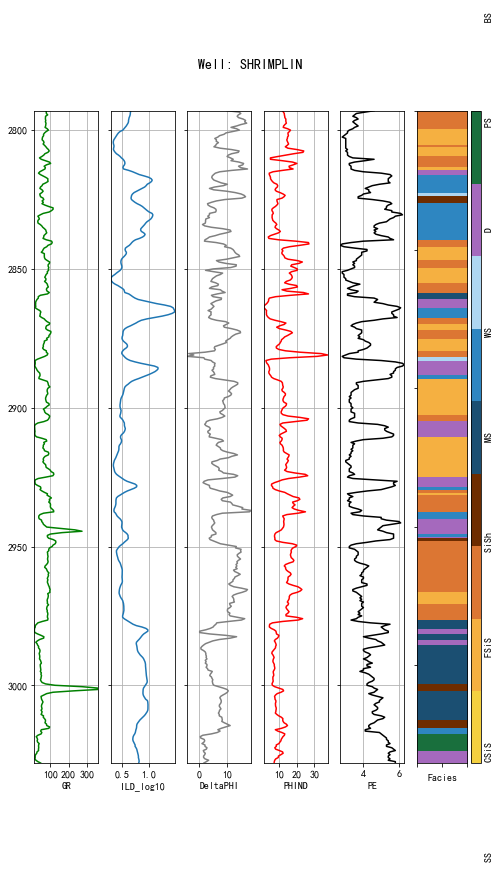

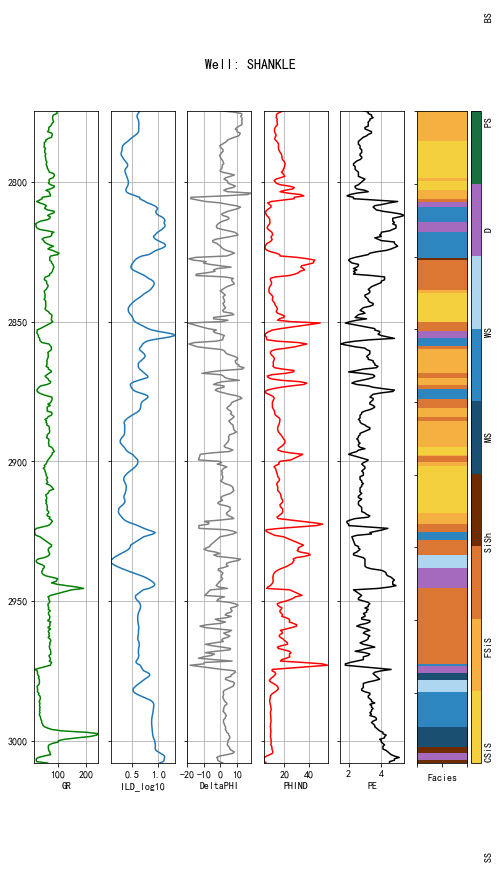

In [9]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHANKLE'],
    facies_colors)

除了单个井，我们还可以查看整个训练集如何表示各个相。 让我们绘制每个相类的训练样例数的直方图。

SS      259
CSiS    640
FSiS    535
SiSh    126
MS      189
WS      366
D        82
PS      442
BS      130
Name: Facies, dtype: int64

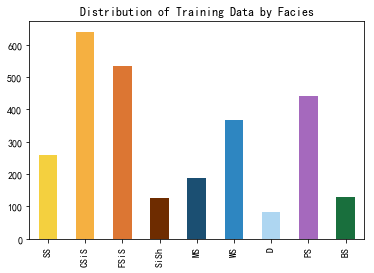

In [10]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

这显示了训练集中3232训练样例的相的示例分布。 白云岩（相7）最少，有141个例子。 还有185个挡板的例子。 根据我们将要训练的分类器的性能，我们可能会考虑获得这些相的更多示例。

交叉图是地球科学中一种熟悉的工具，用于可视化两种属性如何随岩石类型而变化。 此数据集包含5个对数变量，散点矩阵可帮助快速可视化数据集中所有变量之间的差异。 我们可以使用非常有用的来快速创建漂亮的散布矩阵。 图中的每个窗格显示x和y轴上两个变量之间的关系，每个点根据其相位着色。 相同的色图用于表示9个相。

D:\Anaconda3\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
D:\Anaconda3\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
D:\Anaconda3\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


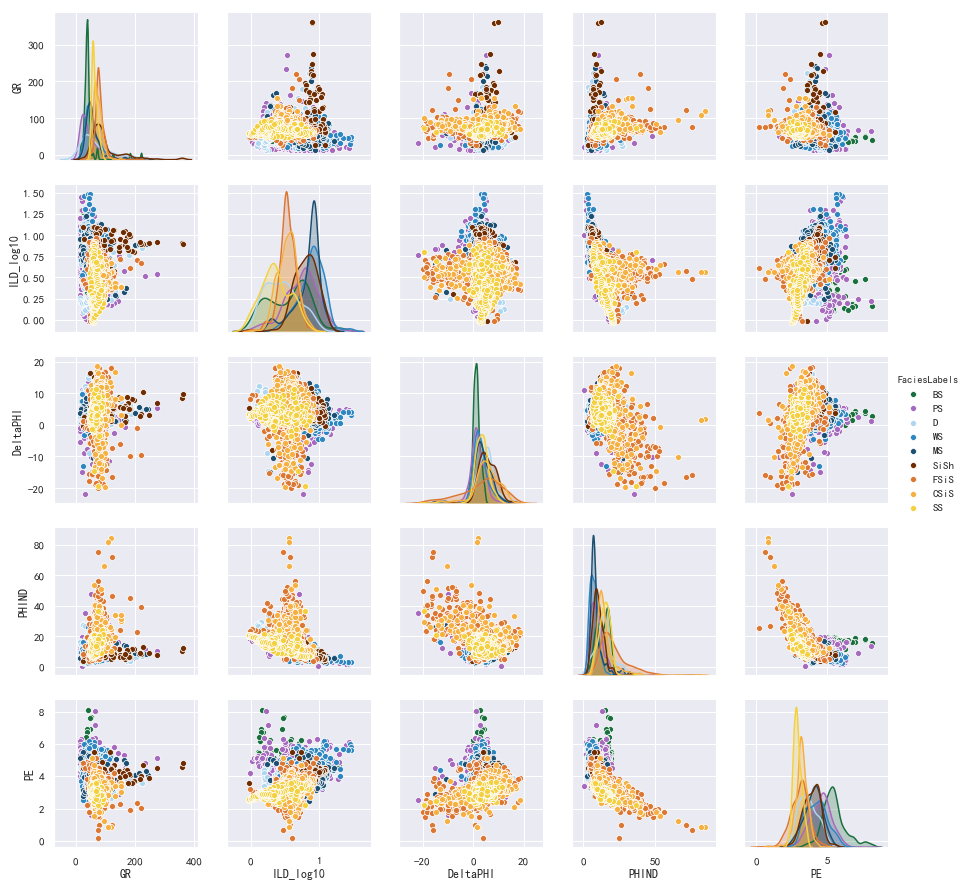

In [11]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

## 调整数据集

现在我们只提取执行分类所需的特征变量。 预测变量是五个有线值和两个地质约束变量。 我们还获得了与每个特征向量对应的相标签的向量。

In [12]:
correct_facies_labels = training_data['Facies'].values
feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000
mean,67.039150,0.637353,3.573298,13.793859,3.717207,1.478873,0.518975
std,30.280378,0.250915,5.270749,8.007659,0.943923,0.499644,0.287105
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,48.125000,0.479863,1.211000,8.450000,3.078000,1.000000,0.269000
50%,66.910000,0.621903,3.500000,12.337000,3.500000,1.000000,0.526000
75%,80.594000,0.819000,6.400000,16.795000,4.371000,2.000000,0.767000
max,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


Scikit包含一个[预处理]（http://scikit-learn.org/stable/modules/preprocessing.html）模块，可以“标准化”数据（给每个变量零均值和单位方差，也称为*白化*）。 许多机器学习算法假设特征将是标准的正态分布数据（即：具有零均值和单位方差的高斯分布）。 用于标准化训练集的因子必须应用于将输入到分类器的任何后续特征集。 标准标量类可以适合训练集，后来用于标准化任何训练数据。

In [13]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)

scaled_features = scaler.transform(feature_vectors)


D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


Scikit还包括一个方便的功能，可以将训练数据随机分成训练和测试集。 测试集包含一小部分特征向量，这些特征向量不用于训练网络。 因为我们知道这些例子的真实相标签，我们可以将分类器的结果与实际相比较，并确定模型的准确性。 让我们将20％的数据用于测试集。

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.2, random_state=42)

训练SVM分类器
现在我们使用经过清洁和调节的训练集来创建一个相分类器。 如上所述，我们将使用一种称为支持向量机的机器学习模型。 SVM是特征向量的映射，作为多维空间中的点，映射使得来自不同相的示例被尽可能宽的清晰间隙划分。
scikit-learn中的SVM实现需要许多重要参数。 首先，我们使用默认设置创建分类器。

In [15]:
from sklearn import svm

clf = svm.SVC()

现在我们可以使用上面创建的训练集训练分类器。

In [16]:
clf.fit(X_train,y_train)

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

现在模型已经对我们的数据进行了训练，我们可以用它来预测测试集中特征向量的相。 因为我们知道测试集中向量的真实相标签，所以我们可以使用结果来评估分类器的准确性。

In [17]:
predicted_labels = clf.predict(X_test)

我们需要一些指标来评估分类器的效果。 [混淆矩阵]（http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/）是一个表，可用于描述分类模型的性能。 [Scikit-learn]（http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html）允许我们通过提供实际和预测的相标签轻松创建混淆矩阵。

混淆矩阵只是一个二维数组。 混淆矩阵“C [i] [j]”的条目等于预测具有相“j”的观测数，但已知有相“i”。

为了简化读取混淆矩阵，已经编写了一个函数来显示矩阵以及相标签和各种误差度量。 请参阅此repo中的文件`classification_utilities.py`以获取`display_cm（）`函数。

In [18]:
from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, hide_zeros=True)

0.6861912522447959
     Pred
   SS
 CSiS
 FSiS
 SiSh
   MS
   WS
    D
   PS
   BS
Total

     True
       SS
   28
   19
    1
     
     
     
     
     
     
   48

     CSiS
    7
  101
   31
     
     
    1
     
     
     
  140

     FSiS
    1
   21
   75
     
     
    2
     
    2
     
  101

     SiSh
     
     
     
   13
     
   12
     
    3
     
   28

       MS
     
    1
    1
     
    1
   29
     
    8
     
   40

       WS
     
     
    1
    4
     
   52
    1
    8
     
   66

        D
     
     
     
     
     
    1
    7
    6
     
   14

       PS
     
     
    1
    2
     
   23
    1
   55
    9
   91

       BS
     
     
     
     
     
     
     
    5
   21
   26



混淆矩阵的行对应于实际的相标签。 列对应于分类器分配的标签。 例如，考虑第一行。 对于实际上具有标记“SS”的测试集中的特征向量，23被正确识别为“SS”，21个被分类为“CSiS”，2个被分类为“FSiS”。

对角线上的条目是已正确分类的相。 下面我们定义两个函数，它们将给出算法执行方式的总体值。 准确度定义为正确分类的数量除以分类总数。

In [19]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

如上所述，相类之间的界限并非都是尖锐的，并且它们中的一些相互融合。 还可以计算这些“相邻相”内的误差。 我们定义一个数组来表示彼此相邻的相。 对于相标记`i`，`adjacent_facies [i]`是相邻相标记的数组。

In [20]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [21]:
print ('Facies classification accuracy = %f' % accuracy(conf))
print ('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.637184
Adjacent facies classification accuracy = 0.927798


## 模型参数选择

到目前为止，分类器已使用默认参数构建。但是，我们可以通过最佳参数选择获得改进的分类结果。

我们将考虑两个参数。参数“C”是一个正则化因子，它告诉分类器我们想要避免错误分类训练样例。较大的C值将尝试从训练集中正确分类更多示例，但如果“C”太大，则可能“过度拟合”数据并且在分类新数据时无法概括。如果`C`太小，那么模型将不适合拟合异常值并且在训练集上会有很大的误差。

SVM学习算法使用核函数来计算特征向量之间的距离。存在许多内核函数，但在这种情况下我们使用径向基函数`rbf`内核（默认）。 'gamma`参数描述了径向基函数的大小，它是特征空间中两个向量需要被认为接近的距离。

我们将训练一系列具有不同“C”和“伽玛”值的分类器。两个嵌套循环用于为指定范围内的每个可能值组合训练分类器。记录每个参数值组合的分类精度。结果显示在一系列图中，因此可以选择在测试集上提供最佳分类精度的参数值。

此过程也称为“交叉验证”。除了训练和测试集之外，通常还会创建单独的“交叉验证”数据集来进行模型选择。在本教程中，我们将使用测试集来选择模型参数。

D:\Anaconda3\lib\site-packages\matplotlib\mathtext.py:843: MathTextWarning: Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
  MathTextWarning)


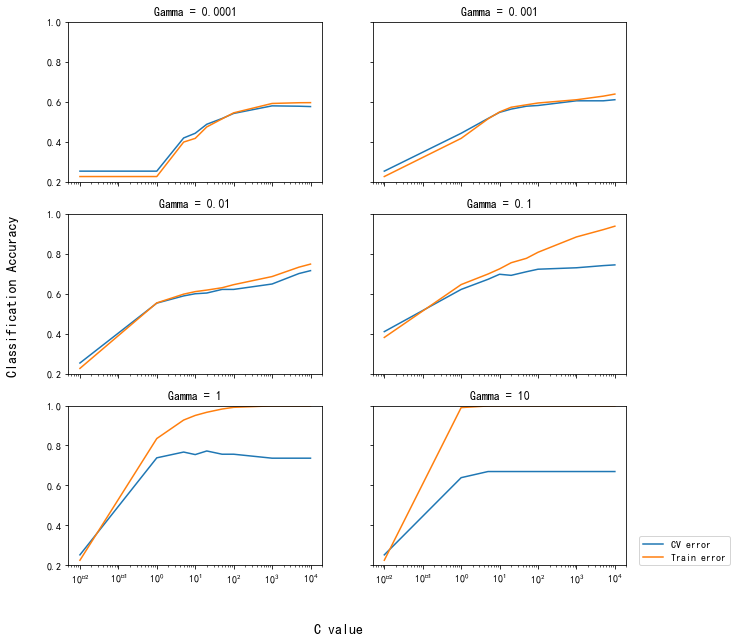

In [22]:
#model selection takes a few minutes, change this variable
#to true to run the parameter loop
do_model_selection = True

if do_model_selection:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
    
    fig, axes = plt.subplots(3, 2, 
                        sharex='col', sharey='row',figsize=(10,10))
    plot_number = 0
    for outer_ind, gamma_value in enumerate(gamma_range):
        row = plot_number / 2
        column = plot_number % 2
        cv_errors = np.zeros(C_range.shape)
        train_errors = np.zeros(C_range.shape)
        for index, c_value in enumerate(C_range):
            
            clf = svm.SVC(C = c_value, gamma = gamma_value)
            clf.fit(X_train,y_train)
            
            train_conf = confusion_matrix(y_train, clf.predict(X_train))
            cv_conf = confusion_matrix(y_test, clf.predict(X_test))
        
            cv_errors[index] = accuracy(cv_conf)
            train_errors[index] = accuracy(train_conf)
            row=int(row)
            column=int(column)
        ax = axes[row, column]
        ax.set_title('Gamma = %g'%gamma_value)
        ax.semilogx(C_range, cv_errors, label='CV error')
        ax.semilogx(C_range, train_errors, label='Train error')
        plot_number += 1
        ax.set_ylim([0.2,1])
        
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    fig.text(0.5, 0.03, 'C value', ha='center',
             fontsize=14)
             
    fig.text(0.04, 0.5, 'Classification Accuracy', va='center', 
             rotation='vertical', fontsize=14)

对于'gamma = 1`和`C = 10`，实现了交叉验证误差曲线的最佳精度。 我们现在可以基于以下参数创建和训练优化的分类器：

In [23]:
clf = svm.SVC(C = 10, gamma = 1)        
clf.fit(X_train,y_train)

cv_conf = confusion_matrix(y_test, clf.predict(X_test))

print ('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print ('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.75
Optimized adjacent facies classification accuracy = 0.93


[精确度和召回]（https://en.wikipedia.org/wiki/Precision_and_recall）是一个指标，可以更深入地了解分类器如何为单个相执行。 精度是给定样本的分类结果的概率，样本实际上属于该类。 回想一下，对于给定的类，样本将被正确分类的概率。

使用混淆矩阵可以轻松计算精度和召回率。 执行此操作的代码已添加到`display_confusion_matrix（）`函数中：

In [24]:
display_cm(cv_conf, facies_labels, 
           display_metrics=True, hide_zeros=True)

0.7563329018083212
     Pred
   SS
 CSiS
 FSiS
 SiSh
   MS
   WS
    D
   PS
   BS
Total

     True
       SS
   42
    6
     
     
     
     
     
     
     
   48

     CSiS
    5
  112
   21
    2
     
     
     
     
     
  140

     FSiS
    4
   17
   75
     
    3
    1
     
    1
     
  101

     SiSh
     
     
    2
   22
     
    3
     
    1
     
   28

       MS
     
    1
    1
    1
   25
    8
    1
    3
     
   40

       WS
     
     
    1
    6
    5
   44
     
   10
     
   66

        D
     
     
    1
     
    1
     
    9
    2
    1
   14

       PS
     
     
    1
    1
    5
   16
    2
   63
    3
   91

       BS
     
     
     
     
     
     
     
     
   26
   26


Precision
 0.82
 0.82
 0.74
 0.69
 0.64
 0.61
 0.75
 0.79
 0.87
 0.76

   Recall
 0.88
 0.80
 0.74
 0.79
 0.62
 0.67
 0.64
 0.69
 1.00
 0.75

       F1
 0.85
 0.81
 0.74
 0.73
 0.63
 0.64
 0.69
 0.74
 0.93
 0.75



要解释这些结果，请考虑相“SS”。在我们的测试集中，如果样品标记为“SS”，则样品正确的概率为0.8（精确度）。如果我们知道样品具有相“SS”，则分类器正确标记的概率为0.78（召回）。期望具有高精度和召回的值，但是通常当算法被调整为增加一个时，另一个减少。 [F1得分]（https://en.wikipedia.org/wiki/Precision_and_recall#F-measure）将两者结合起来，给出了分类器结果相关性的单一度量。

这些结果有助于指导如何改进分类器结果的直觉。例如，对于具有相“MS”或泥岩的样品，它仅在57％的时间内被正确分类（召回）。也许这可以通过引入更多的训练样本来改善。样品质量也可以发挥作用。比赛`BS`或bafflestone拥有最好的'F1`得分和相对较少的训练样例。但这些数据是从其他井中精心挑选出来的，以提供识别该相的训练实例。

当我们考虑将相邻相错误分类为正确时，我们也可以考虑分类指标：


In [25]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies, 
           display_metrics=True, hide_zeros=True)

0.9299336352738489
     Pred
   SS
 CSiS
 FSiS
 SiSh
   MS
   WS
    D
   PS
   BS
Total

     True
       SS
   48
     
     
     
     
     
     
     
     
   48

     CSiS
     
  138
     
    2
     
     
     
     
     
  140

     FSiS
    4
     
   92
     
    3
    1
     
    1
     
  101

     SiSh
     
     
    2
   22
     
    3
     
    1
     
   28

       MS
     
    1
    1
     
   34
     
    1
    3
     
   40

       WS
     
     
    1
    6
     
   59
     
     
     
   66

        D
     
     
    1
     
    1
     
   11
     
    1
   14

       PS
     
     
    1
    1
    5
     
     
   84
     
   91

       BS
     
     
     
     
     
     
     
     
   26
   26


Precision
 0.92
 0.99
 0.94
 0.71
 0.79
 0.94
 0.92
 0.94
 0.96
 0.93

   Recall
 1.00
 0.99
 0.91
 0.79
 0.85
 0.89
 0.79
 0.92
 1.00
 0.93

       F1
 0.96
 0.99
 0.92
 0.75
 0.82
 0.91
 0.85
 0.93
 0.98
 0.93



考虑到相邻相，所有相类型的“F1”得分均高于0.9，除非对“SiSh”或海洋粉砂岩和页岩进行分类。 分类器经常错误地分类这个相（回忆0.66），最常见的是wackestone。

这些结果与Dubois等人报道的结果相当。（2007年）。

## 将分类模型应用于盲数据

我们从训练中退了回来，并将其存储在名为`blind`的数据框中：

In [26]:
blind

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
3282,3,A1 SH,NEWBY,2826.0,76.34,0.719,7.8,11.00,3.7,1,1.000
3283,3,A1 SH,NEWBY,2826.5,83.74,0.688,9.7,12.55,3.4,1,0.977
3284,3,A1 SH,NEWBY,2827.0,83.19,0.664,10.1,11.95,3.4,1,0.953
3285,3,A1 SH,NEWBY,2827.5,80.44,0.648,10.1,11.15,3.4,1,0.930
3286,3,A1 SH,NEWBY,2828.0,75.42,0.648,9.3,11.45,3.3,1,0.907
...,...,...,...,...,...,...,...,...,...,...,...
3740,6,C LM,NEWBY,3055.0,66.94,0.838,4.0,8.00,4.2,2,0.292
3741,6,C LM,NEWBY,3055.5,54.06,0.823,1.9,5.45,4.3,2,0.281
3742,6,C LM,NEWBY,3056.0,47.87,0.797,0.7,4.85,4.4,2,0.270
3743,6,C LM,NEWBY,3056.5,49.34,0.763,2.3,4.85,4.1,2,0.258


The label vector is just the `Facies` column:

In [27]:
y_blind = blind['Facies'].values

我们可以通过删除一些列并创建一个新的数据帧来形成特征矩阵：

In [28]:
well_features = blind.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1)

现在我们可以用我们之前制作的标量来改变它：

In [29]:
X_blind = scaler.transform(well_features)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


现在，进行预测并将其存储在数据框架中是一件简单的事情：

In [30]:
y_pred = clf.predict(X_blind)
blind['Prediction'] = y_pred

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Let's see how we did with the confusion matrix:

In [31]:
cv_conf = confusion_matrix(y_blind, y_pred)

print ('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print ('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.39
Optimized adjacent facies classification accuracy = 0.84


我们使用测试数据管理0.75，但它来自与训练数据相同的井。 这种更合理的测试表现不佳......但在相邻的相预测上表现非常好。

In [32]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies, display_metrics=True, hide_zeros=True)

0.8521212290420527
     Pred
   SS
 CSiS
 FSiS
 SiSh
   MS
   WS
    D
   PS
   BS
Total

     True
       SS
     
     
     
     
     
     
     
     
     
    0

     CSiS
     
   96
     
     
     
     
     
    2
     
   98

     FSiS
    6
     
   71
     
     
     
     
    3
     
   80

     SiSh
     
     
    2
   41
     
    9
    3
    3
     
   58

       MS
     
    2
     
     
   17
     
    1
    8
     
   28

       WS
     
     
    4
    5
     
   85
     
     
    2
   96

        D
     
     
     
     
     
     
   16
     
     
   16

       PS
     
    1
    6
     
    7
     
     
   42
     
   56

       BS
     
     
    3
    2
     
    5
     
     
   21
   31


Precision
 0.00
 0.97
 0.83
 0.85
 0.71
 0.86
 0.80
 0.72
 0.91
 0.85

   Recall
 0.00
 0.98
 0.89
 0.71
 0.61
 0.89
 1.00
 0.75
 0.68
 0.84

       F1
 0.00
 0.97
 0.86
 0.77
 0.65
 0.87
 0.89
 0.74
 0.78
 0.84



C:\Users\pc\Desktop\Facies_GUI\01_Tkinter-Gui-And-ML0918\classification_utilities.py:12: RuntimeWarning: invalid value encountered in true_divide
  recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')


In [33]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

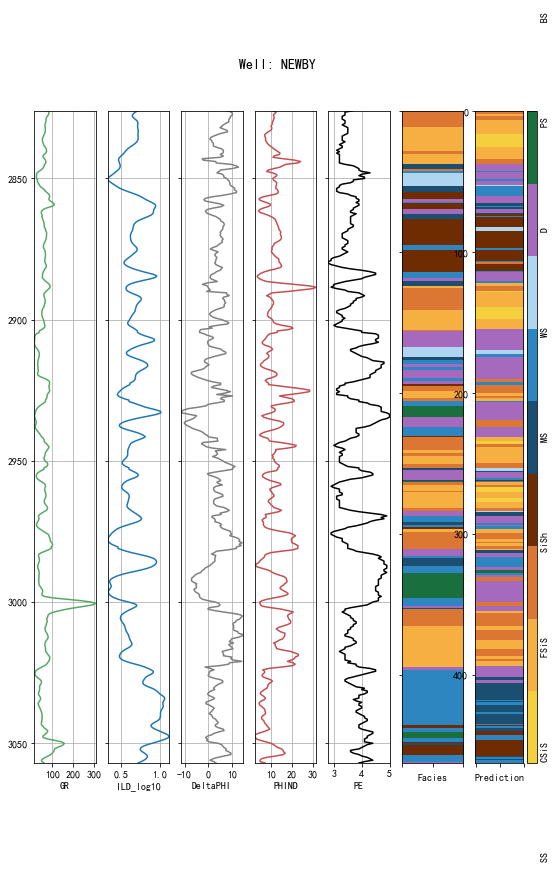

In [34]:
compare_facies_plot(blind, 'Prediction', facies_colors)

## 将分类模型应用于新数据

现在我们已经有一个训练有素的分类模型，我们可以用它来识别没有核心数据的井中的相。 在这种情况下，我们将分类器应用于两个井，但我们可以在任意数量的井上使用它，我们有相同的井测井用于输入。

此数据集与训练数据类似，但它没有相标签。 它被加载到一个名为的数据帧中

In [36]:
well_data = pd.read_csv('validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)

需要使用我们用于训练数据的相同常量来缩放数据。

In [37]:
X_unknown = scaler.transform(well_features)

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


最后，我们预测未知数据的相标签，并将结果存储在`test_data`数据帧的`Facies`列中。

In [38]:
#predict facies of unclassified data
y_unknown = clf.predict(X_unknown)
well_data['Facies'] = y_unknown
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,2
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,3
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,3
...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,3
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,3
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,3
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,3


In [39]:
well_data['Well Name'].unique()

[STUART, CRAWFORD]
Categories (2, object): [STUART, CRAWFORD]

我们可以使用测井图来查看分类结果以及测井记录。

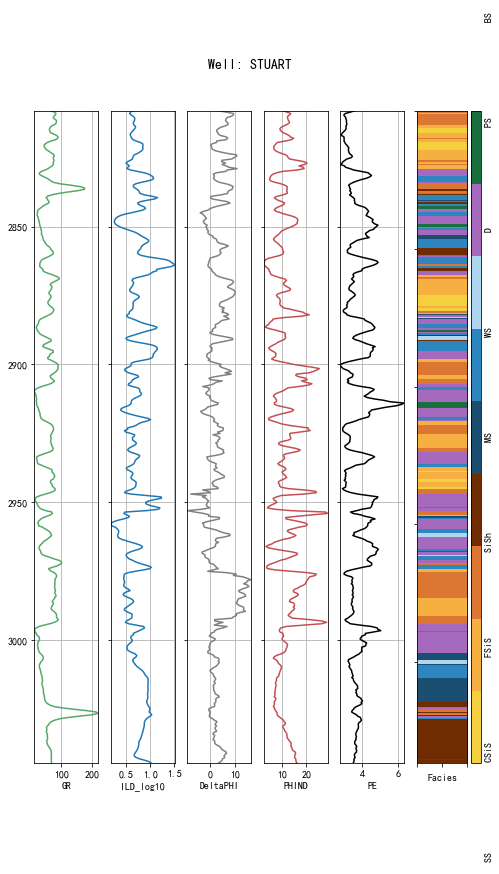

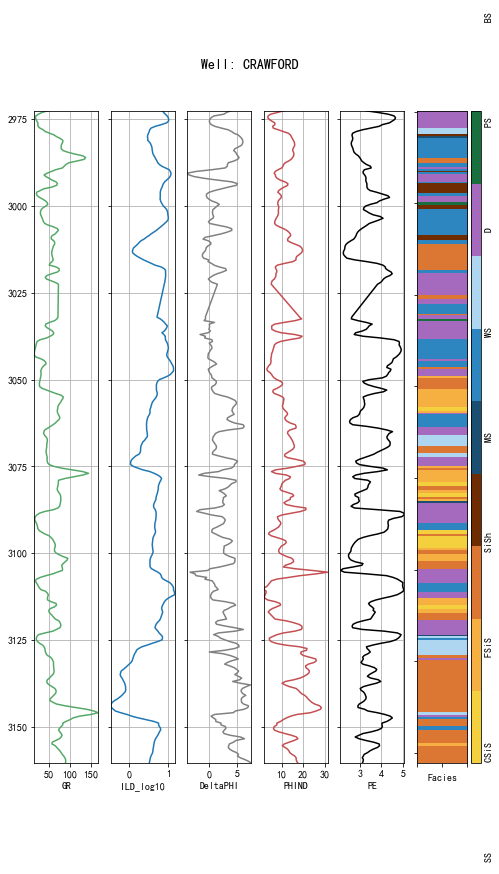

In [40]:
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    well_data[well_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)

最后，我们可以写出一个带有井数据的csv文件以及相分类结果。

In [41]:
well_data.to_csv('well_data_with_facies.csv')

## References

Amato del Monte, A., 2015. Seismic Petrophysics: Part 1, *The Leading Edge*, 34 (4). [doi:10.1190/tle34040440.1](http://dx.doi.org/10.1190/tle34040440.1)

Bohling, G. C., and M. K. Dubois, 2003. An Integrated Application of Neural Network and Markov Chain Techniques to Prediction of Lithofacies from Well Logs, *KGS Open-File Report* 2003-50, 6 pp. [pdf](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf)

Dubois, M. K., G. C. Bohling, and S. Chakrabarti, 2007, Comparison of four approaches to a rock facies classification problem, *Computers & Geosciences*, 33 (5), 599-617 pp. [doi:10.1016/j.cageo.2006.08.011](http://dx.doi.org/10.1016/j.cageo.2006.08.011)